In [2]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import random

#### OLS_scaled

In [16]:
df_tr = pd.read_csv("ML_all_train_updated_v4.csv")
df_t = pd.read_csv("ML_FP_all_test_updated_v5.csv")

# df_tr.shape (17170, 29)
#  df_t.shape (6315, 14)
print(df_tr.columns)
count_tr = df_tr.isna().any(axis=1).sum()
count_t = df_t.isna().any(axis=1).sum()
print("Number of rows with at least one NaN value in train data:", count_tr)
print("Number of rows with at least one NaN value in test data:", count_t)

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Views', 'Likes', 'Stream', 'id', 'Composer', 'Artist',
       'Licensed', 'Album_type', 'official_video'],
      dtype='object')
Number of rows with at least one NaN value in train data: 13460
Number of rows with at least one NaN value in test data: 4955


In [17]:
dep_var = 'Danceability'
indep_var = ['Energy', 'Key', 'Loudness', 'Speechiness', \
     'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', \
     'Duration_ms', 'Views', 'Likes', 'Stream', 'Composer', 'Artist', \
     'Licensed', 'official_video', 'Album_type']
y_tr = df_tr[dep_var]
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]

# Standardize the input features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_t_scaled = scaler.transform(X_t)

# Fill NaN values with scaled median
tr_scaled_median = np.nanmedian(X_tr_scaled, axis=0)
t_scaled_median = np.nanmedian(X_t_scaled, axis=0)
# X_tr_scaled = np.nan_to_num(X_tr_scaled, nan=tr_scaled_median)
# X_t_scaled = np.nan_to_num(X_t_scaled, nan=t_scaled_median)

# Fill NaN values with 0
X_tr_scaled = np.nan_to_num(X_tr_scaled, nan=0)
X_t_scaled = np.nan_to_num(X_t_scaled, nan=0)
X_tr_scaled = pd.DataFrame(X_tr_scaled, columns=indep_var)
X_t_scaled = pd.DataFrame(X_t_scaled, columns=indep_var)

# with statsmodels
X_tr_scaled = sm.add_constant(X_tr_scaled) # adding a constant
X_t_scaled = sm.add_constant(X_t_scaled)

# Fit the robust OLS model
rb_model = sm.RLM(y_tr, X_tr_scaled, M=sm.robust.norms.HuberT())
rb_results = rb_model.fit()

ols_sc_rb_t = rb_results.predict(X_t_scaled)
ols_sc_rb_t = ols_sc_rb_t.round().astype(int)
ols_sc_rb_t = ols_sc_rb_t.clip(0, 9)

ols_sc_rb_t = pd.DataFrame({'id': df_t['id'], 'Danceability': ols_sc_rb_t})
ols_sc_rb_t.to_csv('ols_sc_rb_submission.csv', index=False)

In [6]:
# Perform cross-validation to estimate Ein
cv = KFold(n_splits=5, shuffle=True)
eins = []
for train_index, val_index in cv.split(X_tr_scaled):
    X_train, X_val = X_tr_scaled.iloc[train_index], X_tr_scaled.iloc[val_index]
    y_train, y_val = y_tr.iloc[train_index], y_tr.iloc[val_index]

    rb_model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
    rb_results = rb_model.fit()

    predictions = rb_results.predict(X_val)
    predictions = predictions.round().astype(int)
    predictions = predictions.clip(0, 9)
    
    ein = (predictions != y_val).mean()
    eins.append(ein)

mean_ein = np.mean(eins)

print("Estimated Ein (Cross-Validation):", mean_ein)

Estimated Ein (Cross-Validation): 0.8311589982527664


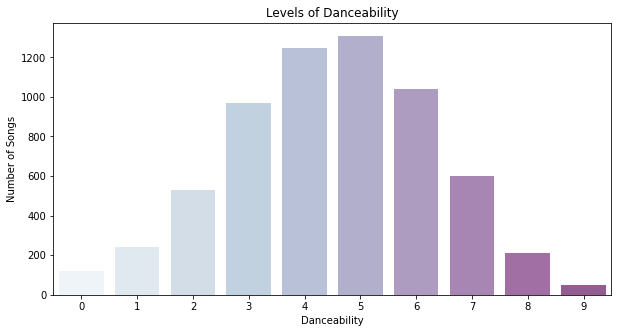

In [18]:
ols_sc_rb_t["Danceability"] = ols_sc_rb_t["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ols_sc_rb_t, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

### Similarity Test

In [15]:
# Read the CSV files
df1 = pd.read_csv('output0511_0408.csv')
df2 = pd.read_csv('ols_sc_rb_submission.csv')

# Get the 'Danceability' values from both DataFrames
danceability1 = set(df1['Danceability'])
danceability2 = set(df2['Danceability'])

count = sum(df1['Danceability'] == df2['Danceability'])
result = (count/6316) * 100

print(f"The similarity between the two CSV files is {result:.5f}%")


The similarity between the two CSV files is 23.38505%


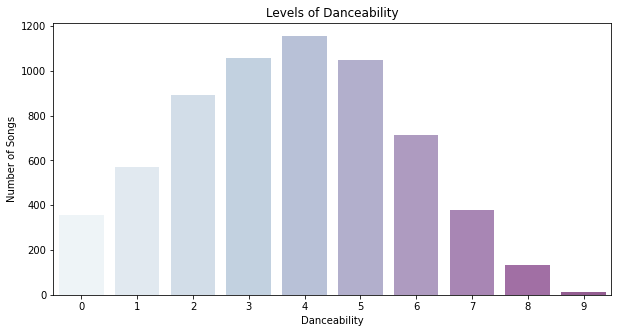

In [8]:
temp_best = pd.read_csv('temp_best.csv')
temp_best["Danceability"] = temp_best["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=temp_best, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()